# Анализ оттока клиентов сети фитнес-центра с помощью машинного обучения

## Цели и задачи проекта

**Цель проекта** - разработать на основе анализа клиентских анкет рекомендации для снижения оттока клиентов сети фитнес-центров.


**Задачи проекта:**

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;

- проанализировать основные признаки, наиболее сильно влияющие на отток;

- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    - *выделить целевые группы клиентов*;
    
    - *предложить меры по снижению оттока*;
    
    - *определить другие особенности взаимодействия с клиентами*.

**Бизнес-задача**: увеличение LTV и прибыли сети фитнес-клубов.

**Тип задачи:** обучение с учителем, задача бинарной классификации.

**Предлагаемые алгоритмы обучения модели:**

- логистическая регрессия;
- случайный лес.

## Описание исходных данных

Исходные данные - данные клиентских анкет, представленные в виде csv-файла, содержащие данные на месяц до оттока и факт оттока на определённый месяц:
- персональные данные клиентов;
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента;
- факт оттока в текущем месяце -`Churn`

## Получение и обзор данных

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

Файл размещен по ссылке: under NDA

Также он размещен в облаке (доступ по ссылке открыт): under NDA

In [2]:
try:
    df = pd.read_csv('under NDA')
except:
    url=' under NDA'
    url='https://drive.google.com/uc?id=' + url.split('/')[-2]
    df = pd.read_csv(url)

In [3]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# размер датасета
df.shape

(4000, 14)

In [5]:
# проверка на пропущенные значения

if df.isna().mean().sum() == 0:
    print('Пропущенных значений нет')
else:
    print('Внимание! Пропущенные значения есть')

Пропущенных значений нет


In [6]:
# проверка на явные дубликаты

if df.duplicated().sum() == 0:
    print('Явных дубликатов нет')
else:
    print('Внимание! Явные дубликаты есть')

Явных дубликатов нет


In [7]:
# проверка категорий данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [8]:
# изменение названий колонок на snake_case формат
df.columns = df.columns.str.lower()

In [9]:
# рассмотрим общие значения признаков
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [10]:
# проверим, чо бинарные переменные, действительно, имеют только 2 уникальных значения и эти значения 0 или 1
df[['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']].apply(['nunique', 'unique'])

,gender,near_location,partner,promo_friends,phone,group_visits,churn
nunique,2,2,2,2,2,2,2
unique,"[1, 0]","[1, 0]","[1, 0]","[1, 0]","[0, 1]","[1, 0]","[0, 1]"


**Промежуточные выводы и задачи для дальнейшего исследовательского анализа данных (EDA)**

**Выводы:**
- пропущенные значения и дубликаты отсутствуют;
- в выборке примерно одинаковое разделение по гендерному признаку;
- категории данных представлены в числовом формате;
- в выборке представлены сведения о клиентах возрастом от 18 до 41 года.

**Целевая переменная** - `churn`, характеризуется бинарной величиной. На основании существующих данных нет возможности проверить наличие временной структуры.

**В объеме EDA целесообразно:**
- рассмотреть распределение числовых признаков (гистограммы);
- оценить наличие выбросов (boxplot);
- рассчитать матрицу корреляций (heatmap);
- рассмотреть, какие признаки наиболее сильно коррелируют с целевой переменной;
- рассмотреть, какие признаки сильно коррелируют между собой;
- построение графиков: признак - целевая переменная.

## Исследовательский анализ данных (EDA)

### Поставновка задач EDA
- рассмотреть средние значения признаков в общих данных, в 2 группах (`churn` = 0, `churn` = 1);
- рассмотреть распределение числовых признаков для 2 групп (гистограммы);
- рассчитать матрицу корреляций (heatmap);
- рассмотреть, какие признаки наиболее сильно коррелируют с целевой переменной.

### EDA

#### Сравнение средних значений в общих данных и в данных 2-х групп (текущие / ушедшие клиенты)

In [11]:
# саздадим 3 таблицы со значениями: количество клиентов в выборке, средние и мединанные значения показателей, значения СКО.
general_df = pd.DataFrame(df.copy().describe().loc[['count', 'mean', '50%', 'std']])
churn_false = pd.DataFrame(df.copy().query('churn == False').describe().loc[['count', 'mean', '50%', 'std']])
churn_true = pd.DataFrame(df.copy().query('churn == True').describe().loc[['count', 'mean', '50%', 'std']])

In [12]:
# проверка размера выборок
if (general_df.loc['count'].mean() - churn_false.loc['count'].mean() - churn_true.loc['count'].mean()) == 0:
    print('Ошибок нет. Сумма размеров выборок churn_false и churn_true равна исходной.')
else:
    print('''Замечена ошибка! Размеры выборок churn_false и churn_true не равны размеру исходной таблицы.
          Необходимо найти причину.''')

Ошибок нет. Сумма размеров выборок churn_false и churn_true равна исходной.


In [13]:
general_df = general_df.T.join(churn_false.T, rsuffix='_churn_false')

In [14]:
general_df = general_df.join(churn_true.T, rsuffix='_churn_true')

In [15]:
# проверка
general_df

,count,mean,50%,std,count_churn_false,mean_churn_false,50%_churn_false,std_churn_false,count_churn_true,mean_churn_true,50%_churn_true,std_churn_true
gender,4000.0,0.510250,1.000000,0.499957,2939.0,0.510037,1.000000,0.499984,1061.0,0.510839,1.000000,0.500118
near_location,4000.0,0.845250,1.000000,0.361711,2939.0,0.873086,1.000000,0.332933,1061.0,0.768143,1.000000,0.422217
partner,4000.0,0.486750,0.000000,0.499887,2939.0,0.534195,1.000000,0.498914,1061.0,0.355325,0.000000,0.478837
promo_friends,4000.0,0.308500,0.000000,0.461932,2939.0,0.353522,0.000000,0.478144,1061.0,0.183789,0.000000,0.387495
phone,4000.0,0.903500,1.000000,0.295313,2939.0,0.903709,1.000000,0.295040,1061.0,0.902922,1.000000,0.296204
contract_period,4000.0,4.681250,1.000000,4.549706,2939.0,5.747193,6.000000,4.716942,1061.0,1.728558,1.000000,2.132371
group_visits,4000.0,0.412250,0.000000,0.492301,2939.0,0.464103,0.000000,0.498795,1061.0,0.268615,0.000000,0.443448
age,4000.0,29.184250,29.000000,3.258367,2939.0,29.976523,30.000000,3.009933,1061.0,26.989632,27.000000,2.895163
avg_additional_charges_total,4000.0,146.943728,136.220159,96.355602,2939.0,158.445715,149.881171,99.801599,1061.0,115.082899,103.814686,77.696419
month_to_end_contract,4000.0,4.322750,1.000000,4.191297,2939.0,5.283089,6.000000,4.363522,1061.0,1.662582,1.000000,1.964593


In [16]:
# создание списка с бинарными параметрами и списка с небинарными параметрами
binary_parameters = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']
non_binary_parameters = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

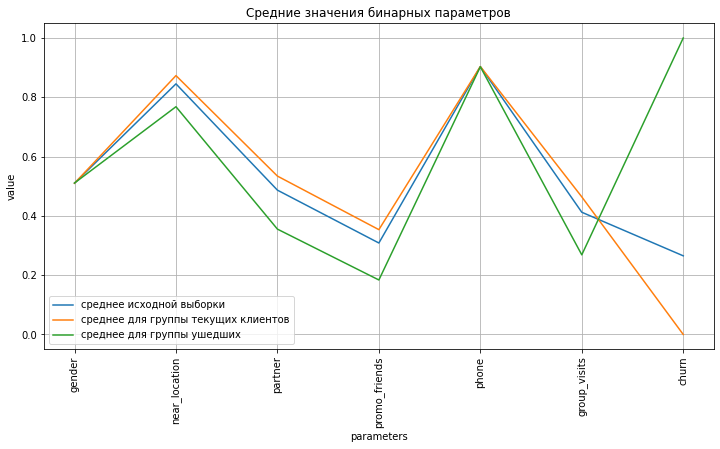

In [17]:
general_df.loc[binary_parameters][['mean', 'mean_churn_false', 'mean_churn_true']] \
             .plot(grid=True, figsize=(12, 6), xlabel='parameters', ylabel='value', \
                   title='Средние значения бинарных параметров')
plt.xticks(rotation=90)
#plt.legend()
plt.legend(labels=['среднее исходной выборки', 'среднее для группы текущих клиентов', 'среднее для группы ушедших'])
plt.show()

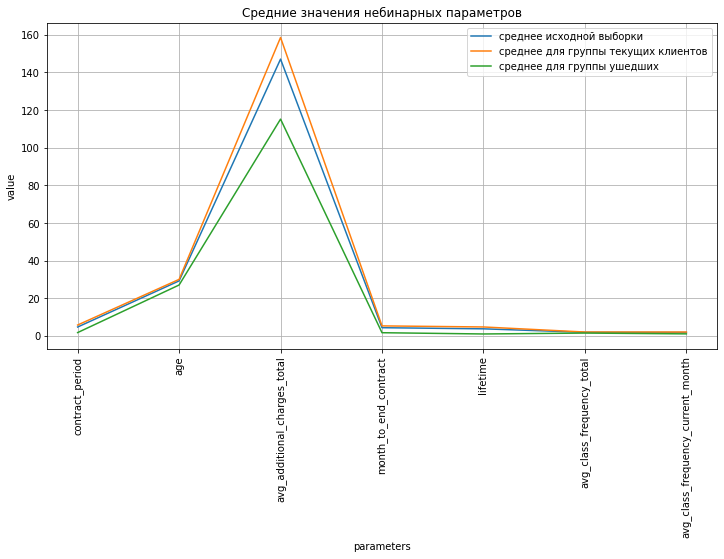

In [18]:
general_df.loc[non_binary_parameters][['mean', 'mean_churn_false', 'mean_churn_true']] \
             .plot(grid=True, figsize=(12, 6), xlabel='parameters', ylabel='value', \
                   title='Средние значения небинарных параметров')
plt.xticks(rotation=90)
plt.legend(labels=['среднее исходной выборки', 'среднее для группы текущих клиентов', 'среднее для группы ушедших'])
plt.show()

По графикам можно сделать предварительные предположения о том, что на лояльность клубу (обратная величина оттоку) могут влиять следующие факторы:
- близкое расположения клуба к дому;
- работе в компании - партнере клуба;
- начало посещения по промо-приглашению;
- посещение групповых занятий;
- суммарная выручка от других услуг фитнес-центра.

#### Распределение числовых признаков для 2-х групп (текущие / ушедшие клиенты)

Построим гистограммы распределения небинарных параметров для того, чтобы увидеть нормальность распределения и наличие выбросов.

In [19]:
# создадим 2 таблицы для 2-х групп (текущие и ушедшие клиенты) только с количественными небинарными параметрами
df_non_binary_churn_false = df.query('churn == 0')[non_binary_parameters]
df_non_binary_churn_true = df.query('churn == 1')[non_binary_parameters]

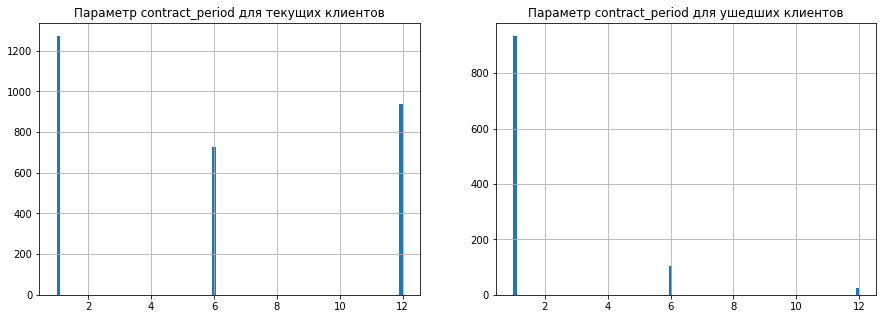

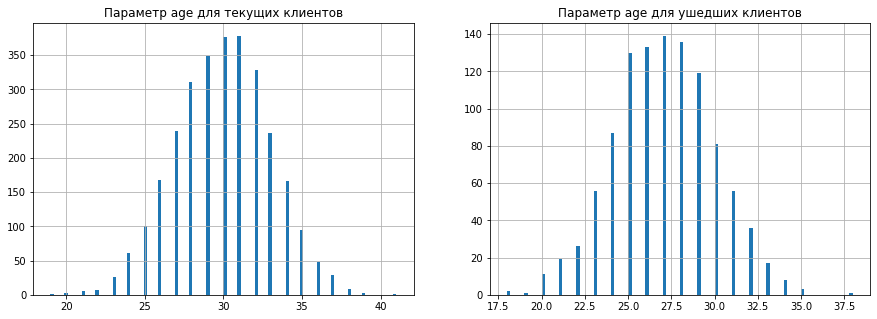

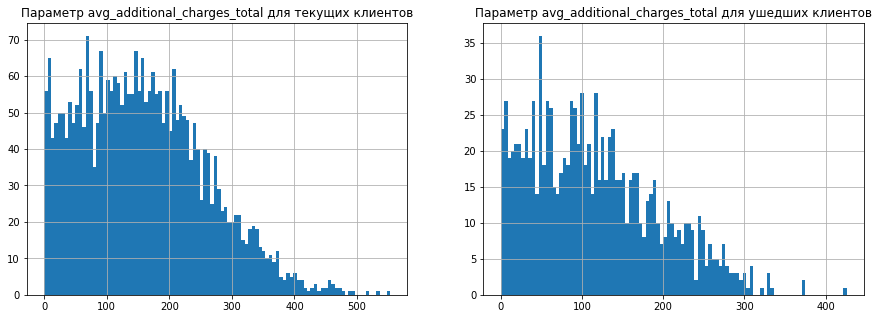

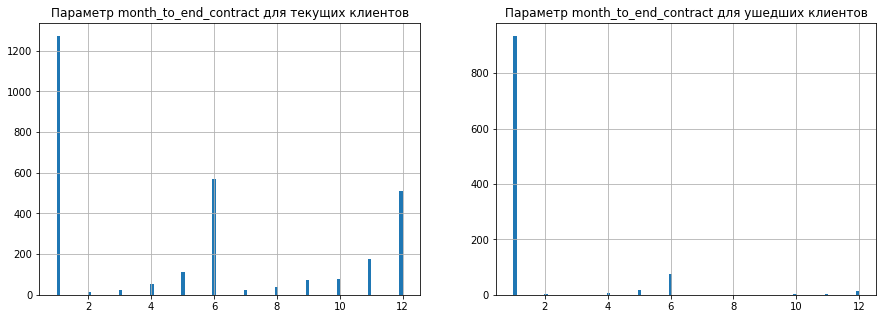

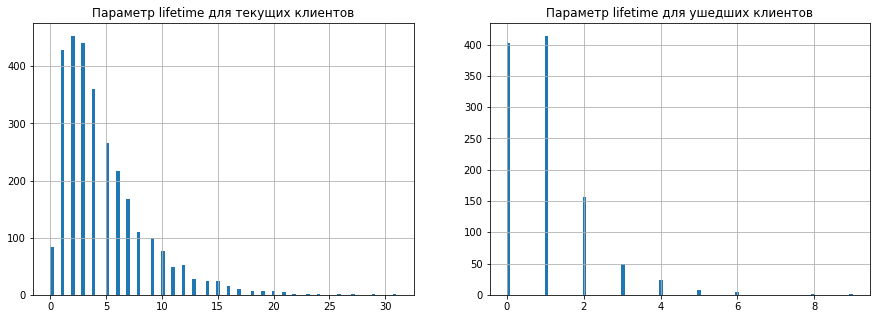

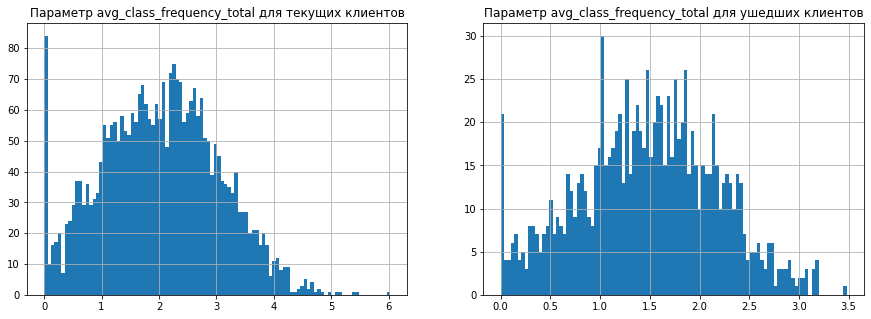

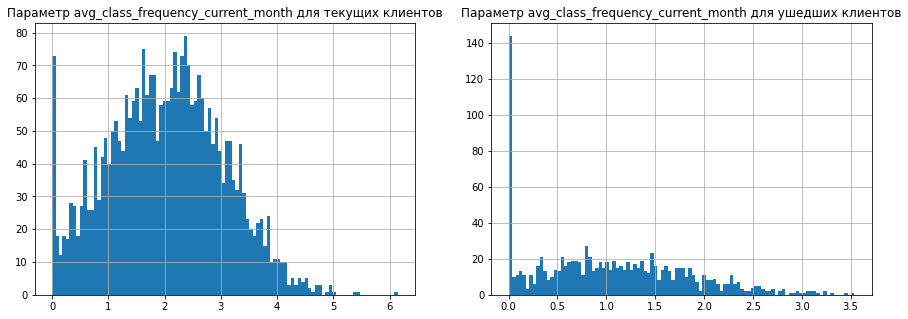

In [20]:
# построим гистограммы распределения небинарных параметров для текущих клиентов
for col in df_non_binary_churn_false.columns:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plt.grid()
    ax[0].hist(df_non_binary_churn_false[col], bins=100)
    ax[0].set_title(f'Параметр {col} для текущих клиентов')
    ax[0].grid()
    ax[1].hist(df_non_binary_churn_true[col], bins=100)
    ax[1].set_title(f'Параметр {col} для ушедших клиентов')
    plt.show()

Анализ гистограмм показывает следующее:
- у подавляющего большинства ушедших клиентов длительность текущего действующего абонемента была 1 месяц;
- распределение возраста клиентов для обеих групп нормальное, но среднее значение возраста текущих клиентов - 30 лет, ушедших - 27 лет;
- характер распределения суммарной выручки от других услуг фитнес-центра похож в обеих группах. Абсолютные средние значения для текущих и ушедших клиентов отличаются: 158 против 115;
- продолжительность посещения (lifetime) для обеих групп очень разная: для текущих клиентов средний период - более 4 мес. (максимальное значение - более 30 мес.), у ушедших - 1 мес. (максимум - 9 мес.);
- частота посещений текущих клиентов за весь период действитя абонемента - около 2 р. в неделю, для ушедних - около 1,5 посещений. Разница выглядит не очень существенной, однако количество посещений за месяц до ухода резко сокращается - до 1 посещения в неделю в то время, как у текущих клиентов оно почти не меняется.

#### Матрица корреляций

In [21]:
df_corr = df.corr()

<AxesSubplot:>

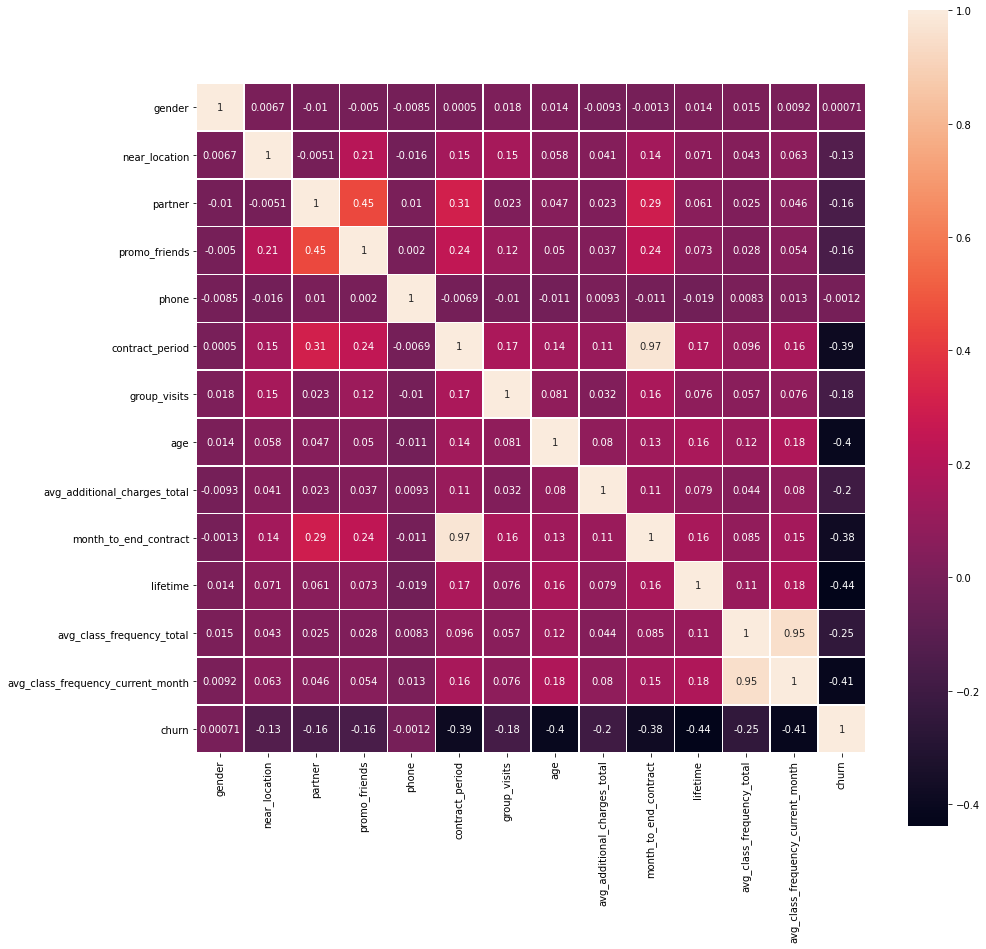

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_corr, annot=True, linewidths=.5, square=True, ax=ax)

Наиболее коррелирующие признаки с признаком оттока (churn):
- общий период взаимодействия к клубом (lifetime) - 0.44;
- частота посещений в неделю - 0.41;
- возраст - 0.4;
- длительность текущего действующего абонемента - 0.39.
При анализе таблицы корреляций смотрим на модуль коэффициента корреляции, так как часто признаки обратно пропорциональных признаку оттока.

Также замечены мультиколлениарные признаки:
- `срок действующего абонемента` и `количество месяцев до конца абонемента`,
- `средняя частота посещений в неделю за период действия абонемента` и `средняя частота посещений в неделю за последний месяц`.

Для повышения качества будущей прогнозной модели, удалим признаки `month_to_end_contract`, `avg_class_frequency_current_month`.

In [23]:
df = df.drop(columns=['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1)

In [24]:
# проверка
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0


### Выводы

В исследовательском анализе данных рассмотрены:
- средние значения признаков и распределение числовых признаков для 2 групп (`churn` = 0, `churn` = 1). 
    
    Сделаны выводы, что в зоне риска ухода:
        - клиенты с текущим действующим абонементом 1 месяц;
        - молодые люди, в среднем, 27 лет;
        - платящие, в среднем, меньше, чем постоянные члены клуба, за другие услуги фитнес-центра;
        - клиенты, имеющие историю посещения клуба менее или около 1 мес.;
        - клиенты с количеством посещений за месяц не более 1 посещения в неделю.
- построена матрица корреляций (heatmap), выполнен анализ того, какие признаки наиболее сильно коррелируют с целевой переменной. 
    
    Сделаны выводы, что с оттоком коррелируют:
        - общий период взаимодействия к клубом (lifetime);
        - частота посещений в неделю;
        - возраст;
        - длительность текущего действующего абонемента.

## Построение модели прогнозирования оттока клиентов

### Постановка задачи моделирования

**Основаная цель** - обучение модели бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

**Задачи**:
- разбить данные на обучающую и валидационную выборку;
- обучить модель:
    - логистической регрессией;
    - случайным лесом;
- оценить метрики accuracy, precision и recall для обеих моделей;
- сделать вывод, какая модель показала себя лучше на основании метрик.

### Построение модели

#### Деление выборки на train и val выборки

In [25]:
# выделяем признаки (матрица X) и целевую переменную (y)
X = df.drop(columns=['churn'], axis=1)
y = df['churn']

In [26]:
# делим на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [27]:
# проверка разбиения по распределению классов в переменной `churn`
print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_train по классам: [2351  849]
Количество строк в y_test по классам: [588 212]


In [28]:
# стандартизация данных: обучение StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [29]:
# преобразование обучающего и валидационного набора данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

#### Создание и обучение модели логистической регрессии. Расчет метрик Accuracy, Precision, Recall, F1, ROC-AUC

In [30]:
# найдем наилучшие параметры для модели логистической регрессыы с помощью автоматического подбирания параметров GridSearchCV
clf = LogisticRegression()

In [31]:
parametrs = {'C': range (1, 10)}

In [32]:
grid = GridSearchCV(clf, parametrs, cv=5)

In [33]:
grid.fit(X_train_st, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': range(1, 10)})

In [34]:
# получение лучших параметров для модели логистической регрессии
grid.best_params_

{'C': 2}

In [35]:
model_log_reg = LogisticRegression(solver='liblinear', C=grid.best_params_['C'], random_state=42)

In [36]:
# обучение модели
model_log_reg.fit(X_train_st, y_train)

LogisticRegression(C=2, random_state=42, solver='liblinear')

In [37]:
# получим вероятности отнесения наблюдения к одному из классов для расчета метрики ROC-AUC
probabilities_log_reg = model_log_reg.predict_proba(X_test_st)[:,1]

In [38]:
# проверка
probabilities_log_reg[0:10]

array([1.54396358e-02, 3.78610953e-01, 7.25046166e-01, 6.01584028e-02,
       7.48613793e-04, 1.04489415e-03, 1.09791714e-02, 5.68171655e-10,
       7.28625596e-03, 3.65897182e-02])

In [39]:
# получим коэффициенты модели
dict(zip(X.columns, model_log_reg.coef_[0]))

{'gender': 0.02897178315837847,
 'near_location': -0.08531163835409264,
 'partner': -0.01941375056741894,
 'promo_friends': -0.18700019712564456,
 'phone': -0.1057057692692098,
 'contract_period': -1.3645762942026298,
 'group_visits': -0.356597723484929,
 'age': -1.171081760211074,
 'avg_additional_charges_total': -0.5529218887050288,
 'lifetime': -3.7972278170273026,
 'avg_class_frequency_total': -0.6922582653483621}

In [40]:
pd.DataFrame(dict(zip(X.columns, model_log_reg.coef_[0])), index=['coef']).T.sort_values(by='coef', ascending=False)

,coef
gender,0.028972
partner,-0.019414
near_location,-0.085312
phone,-0.105706
promo_friends,-0.187000
group_visits,-0.356598
avg_additional_charges_total,-0.552922
avg_class_frequency_total,-0.692258
age,-1.171082
contract_period,-1.364576


Наибольше влияние оказывают параметры частоты посещений в течение действующего абонемента, частоты посещений в течение последнего месяца, общее количество месяцев пользование услугами клуба.

In [41]:
predictions_log_reg = model_log_reg.predict(X_test_st)

In [42]:
# создадим таблицу для записи результатов расчетов метрик
metrix_matrix = pd.DataFrame({'logistic_regression': [0, 0, 0, 0, 0], 'random_tree': [0, 0, 0, 0, 0]}, 
                             index=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [43]:
# проверка
metrix_matrix

,logistic_regression,random_tree
accuracy,0,0
precision,0,0
recall,0,0
f1,0,0
roc_auc,0,0


In [44]:
# запись метрик Accuracy, Precision, Recall в таблицу
metrix_matrix['logistic_regression'] = [round(accuracy_score(y_test, predictions_log_reg), 2), \
                                        round(precision_score(y_test, predictions_log_reg), 2), \
                                        round(recall_score(y_test, predictions_log_reg), 2), \
                                        round(f1_score(y_test, predictions_log_reg), 2), \
                                        round(roc_auc_score(y_test, probabilities_log_reg))]

In [45]:
metrix_matrix

,logistic_regression,random_tree
accuracy,0.90,0
precision,0.84,0
recall,0.79,0
f1,0.81,0
roc_auc,1.00,0


#### Создание и обучение модели Случайный лес. Расчет метрик Accuracy, Precision, Recall, F1

In [46]:
# найдем наилучшие параметры для модели Случайный лес с помощью автоматического подбирания параметров GridSearchCV
clf = RandomForestClassifier()

In [47]:
parametrs = {'n_estimators': range (10, 100, 10),
             'max_depth': range (1, 10)}

In [48]:
grid = GridSearchCV(clf, parametrs, cv=5)

In [49]:
grid.fit(X_train_st, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(10, 100, 10)})

In [50]:
# получение лучших параметров для можели Случайного леса
grid.best_params_

{'max_depth': 9, 'n_estimators': 90}

In [51]:
# создадим модель, применив ранее найденные наилучшие параметры
model_tree = RandomForestClassifier(n_estimators = grid.best_params_['n_estimators'], 
                                    max_depth=grid.best_params_['max_depth'], 
                                    random_state=42)

In [52]:
# обучение модели
model_tree.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=9, n_estimators=90, random_state=42)

In [53]:
# получим вероятности отнесения наблюдения к одному из классов для расчета метрики ROC-AUC
probabilities_tree = model_tree.predict_proba(X_test_st)[:,1]

In [54]:
# проверка
probabilities_tree[0:10]

array([0.13932757, 0.22512039, 0.59286868, 0.08437153, 0.00461622,
       0.00178561, 0.06407925, 0.01578973, 0.0277208 , 0.12714537])

In [55]:
predictions_tree = model_tree.predict(X_test_st)

In [56]:
# запись метрик Accuracy, Precision, Recall в таблицу
metrix_matrix['random_tree'] = [round(accuracy_score(y_test, predictions_tree), 2), \
                                        round(precision_score(y_test, predictions_tree), 2), \
                                        round(recall_score(y_test, predictions_tree), 2), \
                                        round(f1_score(y_test, predictions_log_reg), 2), \
                                        round(roc_auc_score(y_test, probabilities_tree))]

In [57]:
metrix_matrix

,logistic_regression,random_tree
accuracy,0.90,0.90
precision,0.84,0.85
recall,0.79,0.77
f1,0.81,0.81
roc_auc,1.00,1.00


Модель логистической регрессии показывает себя на рассматриваемой выборке лучше - на основании метрики Recall ближе к 1 (единице). Метрики Accuracy, Precision, F1, ROC-AUC для обоих моделей равны.

### Выводы

Создано и обучно 2 модели:

    - логистической регрессией;
    - случайным лесом.
    
По результатам сравнения метрик accuracy, precision и recall для обеих моделей был сделан вывод, что модель логистической регрессии даёт более точное предсказание.

## Кластеризация клиентов

### Постановка задачи кластеризации

**Основаная цель** - обучение модели кластеризации клиентов алгоритмом KMeans для выявления групп клиентов с наиболее похожими значениями признаков для выявления признаков оттока.

**Задачи**:
- стандартизировать данные;
- построить матрицу расстояний;
- обучить модель на основании алгоритма K-Means и спрогнозируйте кластеры клиентов;
- рассмотреть средние значения признаков для кластеров;
- построить распределения признаков для кластеров;
- рассчитать долю оттока для каждого кластера.

### Стандартизация данных

In [58]:
sc = StandardScaler()

In [59]:
df_sc = sc.fit_transform(df)

### Построение матрицы расстояний

In [60]:
# построение матрицы расстояний на стандартизированной выборрке df_sc с применением метода `linkage`
linked = linkage(df_sc, method = 'ward')

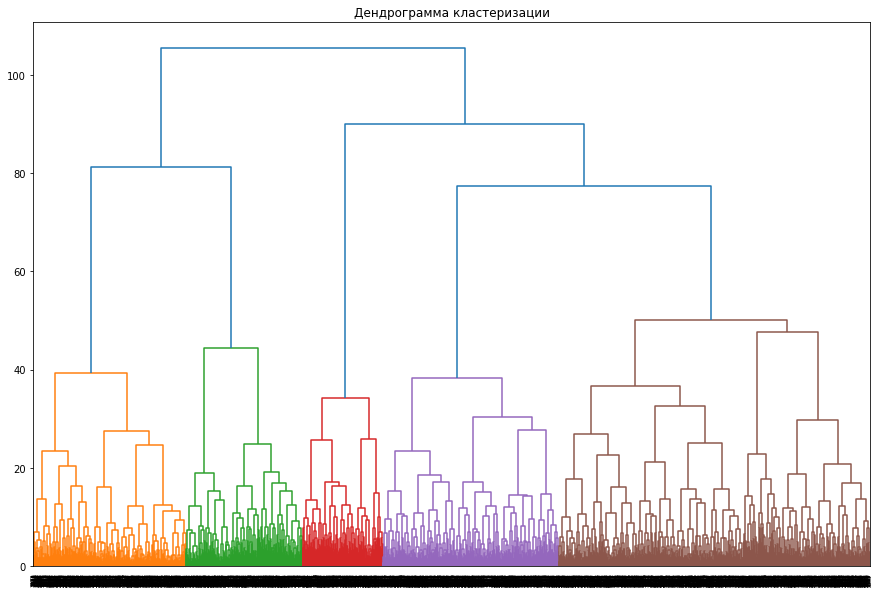

In [61]:
# построение дендрограммы
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Дендрограмма кластеризации')
plt.show()

Явно выделяется 5 классов

### Создание и обучение модели кластеризации на основании алгоритма K-Means

In [62]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=42)

In [63]:
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(df_sc)

In [64]:
# сохраняем метки кластера
df_clusters_labels = df.copy()

In [65]:
df_clusters_labels['cluster_km'] = labels

In [66]:
# проверка
df_clusters_labels.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0,4
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0,2
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0,2
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0,0


### Построениие распределения признаков для кластеров

In [67]:
# рассмотрим средние значениям признаков по кластерам
df_clusters_labels_grouped = df_clusters_labels.groupby('cluster_km', as_index=False).mean()

In [68]:
df_clusters_labels_grouped

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,0,0.507659,0.993435,0.851204,1.000000,1.0,7.311816,0.541575,29.912473,157.562216,4.733042,2.023697,0.012035
1,1,0.510316,1.000000,0.327373,0.220083,1.0,1.698762,0.286107,26.899587,114.139664,0.973865,1.473279,0.991747
2,2,0.512730,0.999293,0.336634,0.000000,1.0,5.144272,0.458274,30.045262,161.669017,4.712164,2.045793,0.000707
3,3,0.499106,0.000000,0.488372,0.075134,1.0,3.021467,0.237925,28.708408,136.885800,3.007156,1.765421,0.402504
4,4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


Характерные особенности групп клиентов:
- **группа 0**: ок. 45% являются сотрудниками компаний-партнеров клуба, почти не являются промо-клиентами, 3-месячные договора с клубом, это не первый их контракт, посещают клуб нечасто (1 раз в неделю);
- **группа 1**: 80% являются сотрудниками компаний-партнеров клуба, больше 50% являются промо-клиентами, в среднем 11-месячные договора с клубом, посещают клуб часто (2 раза в неделю);
- **группа 2**: менее 40% являются сотрудниками компаний-партнеров клуба, почти не являются промо-клиентами, 3-месячные договора с клубом, посещают клуб очень часто (3 раза в неделю);
- **группа 3**: ок. 45% являются сотрудниками компаний-партнеров клуба, ок. 30% являются промо-клиентами, в среднем 5-месячные договора с клубом, посещают клуб нечасто (1-2 раза в неделю);
- **группа 4**: менее 40% являются сотрудниками компаний-партнеров клуба, менее 20% являются промо-клиентами, в среднем менее 2-месячные договора с клубом, посещают клуб редко (1 раз в неделю).

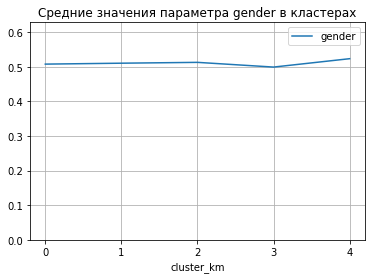

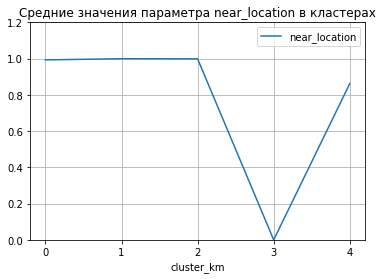

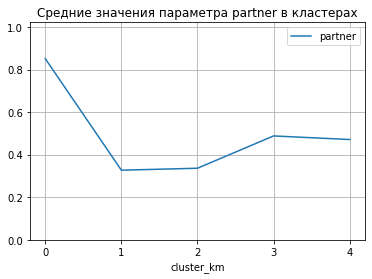

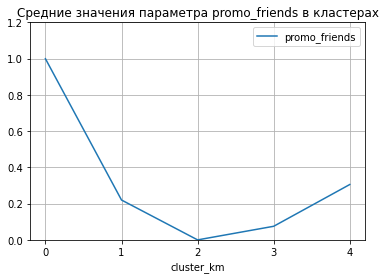

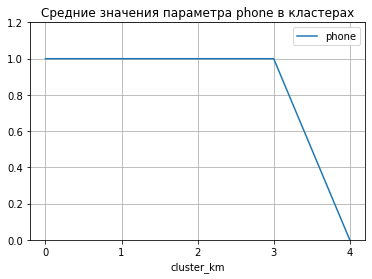

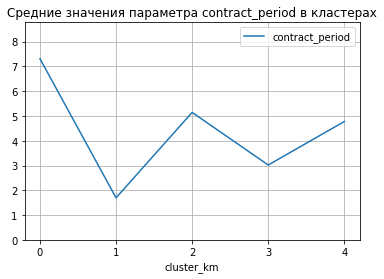

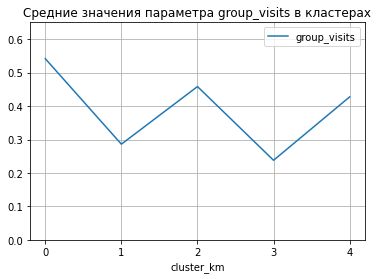

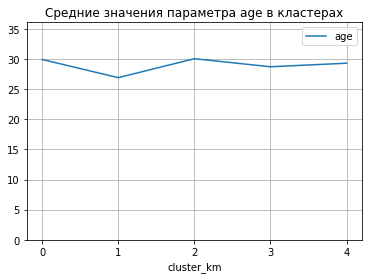

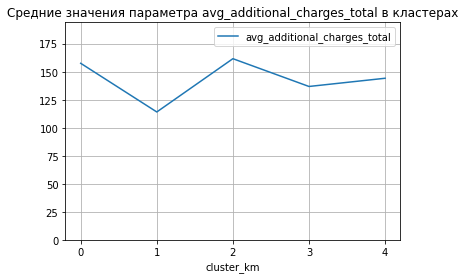

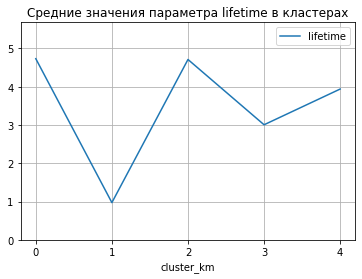

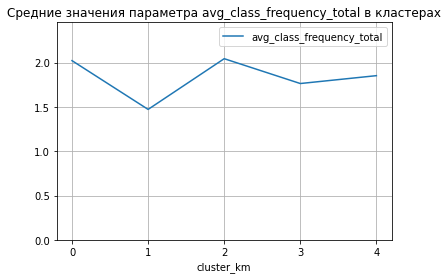

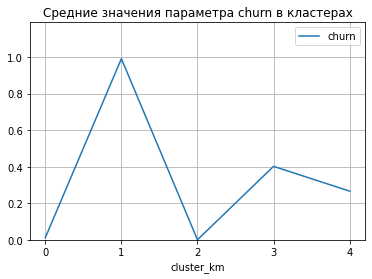

In [69]:
for col in df_clusters_labels_grouped.drop(columns=['cluster_km'], axis=1).columns:
    df_clusters_labels_grouped.plot(x='cluster_km', y=col, grid=True)
    plt.ylim(0, df_clusters_labels_grouped[col].max()*1.2)
    plt.xticks(df_clusters_labels_grouped.cluster_km.unique())
    plt.title(f'Средние значения параметра {col} в кластерах')
    plt.show()

Выводы по результатам анализа средних значений параметров:
- наибольшие различия заметны в параметрах:
    - `contract_period`, `month_to_end_contract`, `partner` (существенно отличается в большую сторону у кластера 1),
    - `promo_friends` (меньше всего значение в кластере 4 и больше всего в кластере 1)
    - `avg_additional_charges_total` (значение в кластере 4 заметно меньше, чем в других кластерах),
    - `lifetime` (значение в кластере 4 заметно меньше, чем в других кластерах),
    - `phone` (равен 0 в кластере 3 и для остальных кластеров - почти 1),
    - `avg_class_frequency_total`, `avg_class_frequency_current_month` (выделяются в большую сторону для кластера 2)
- средние значения параметров отличаются, но драматических изменений не зметно: `gender`, `near_location`, `group_visits`, `age`.

### Расчет доли оттока для каждого кластера

In [70]:
df_clusters_labels_grouped[['churn']].sort_values(by='churn')

,churn
2,0.000707
0,0.012035
4,0.266839
3,0.402504
1,0.991747


Вывод:
- наименее склонны к оттоку кластеры 0, 2, 1 (в порядке возрастаний вероятности оттока);
- самый склонный к оттоку кластер - 4 (вероятность почти - 1).

## Выводы и базовые рекомендации по работе с клиентами

**Выводы**:
- в проекте получены данные клиентов фитнес-клуба для прогноза вероятности оттока клиентов;
- данные успешно получены, выполнена предобработка и исследовательский анализ;
- сделаны выводы, что в зоне риска ухода:
        - клиенты с текущим действующим абонементом 1 месяц;
        - молодые люди, в среднем, 27 лет;
        - платящие, в среднем, меньше, чем постоянные члены клуба, за другие услуги фитнес-центра;
        - клиенты, имеющие историю посещения клуба менее или около 1 мес.;
        - клиенты с количеством посещений за месяц не более 1 посещения в неделю.    
- сделаны выводы, что с оттоком коррелируют:
        - общий период взаимодействия к клубом (lifetime);
        - частота посещений в неделю;
        - возраст;
        - длительность текущего действующего абонемента.
- созданы 2 модели предсказания того, будет ли клиент продолжать пользоваться услугами клуба или покинет его (модель логистической регресии и модель случайного леса). Лучшую эффективность показала модель логистической регрессии. Наиболее сильными факторами являются: частота посещений в течение действующего абонемента, частота посещений в течение последнего месяца, общее количество месяцев пользование услугами клуба.
- выполнено разбиение клиентов клуба на 5 групп по особенностям взаимодействия с фитнес-клубом.


**Рекомендации (маркетинговые действия)**:
- увеличить общий период взаимодействиия клиента и клуба - предложить клиентам к абонементу на 1 месяц подарок в виде абонетемента ещё на несколько месяцев;
- увеличить средние траты клиентов на клубные продукты: кафе, спорттовары, косметический и массажный салон, например, внедрив накопление баллов на клубной карте за подобные траты и возможность их использования для продления абонемента;
- увеличить среднего количества посещений клиентами клуба - например, добавить в услуги клуба мастер-классы, классы о валеологии, здоровье, разработке индивидуальных планов и т.д.;
- привлекать больше сотрудников компаний-партнеров - расширить количество компаний-партнеров, например, особенно, крупных организаций где существует устойчивая корпоративная культура.